## PREDICTING BIKE SHARING DEMAND

### Introduction

This project analyzes data from a Bikeshare program in Washington, D.C. Predicting demand can help businesses/companies improve customer experience by preparing for possible spikes and limiting delays. The goal of this project is to train and optimize a machine learning model to predict bike rental demand in the Capital Bikeshare program. 

#### Data sources:

The csv files used in this project were provided by Kaggle.

### Scoping

- Load and Investigate Data


- Exploratory Data Analysis
    - What season does each of the season labels represent?
    - How do weather conditions affect bike rentals?
    - What is the rental trend across years, months, days & hours?
    - What is the correlation between target variable `count` and the other variables?


- Data Preprocessing
    
    
- Machine Learning Modeling & Evaluation
    - Linear Regression
    - Random Forest Regression
    - K Nearest Neighbors
    - Auto Gluon


- Conclusion


- Predicting on new data

In [4]:
# !pip install -U pip
# !pip install -U setuptools wheel
# !pip install -U "mxnet<2.0.0" bokeh==2.0.1
# !pip install autogluon --no-cache-dir

### Import Modules

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from autogluon.tabular import TabularPredictor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score

plt.rcParams['figure.figsize'] = [6, 6]
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Load and Investigate Data

The `train.csv` file, loaded into `df`, contain data for bike rental count for 2011 & 2012, precisely 1st through 19th of January through December. `df` has 12 columns & 10,886 rows.

##### Data Characteristics:

The `df` columns include:

- **datetime**: year, month, day & hour
- **season**: four seasons, labeled 1, 2, 3, or 4
- **holiday**: whether a day is considered a holiday or not, labeled 1 or 2
- **workingday**: whether a day is a workingday or not, labeled 1 or 2
- **weather**: four weather conditions, labeled 1, 2, 3, or 4
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- **temp**: temperature in celsius
- **atemp**: 'Feels like' temperature in celsius
- **humidity**: humidity in percentage
- **windspeed**: windspeed
- **casual**: number of non-registered users
- **registered**: number of registered users
- **count**: number of bike rentals


The `test.csv` file, loaded into `prediction_df`, contain data for bike rental for 2011 & 2012, precisely 20th through end of month(January through December). `prediction_df` has 9 columns & 6,493 rows. `prediction_df` include the same columns as df_train excluding the 'casual', 'registered' & 'count' columns. `prediction_df` data will be used for prediction while the `sampleSubmission.csv` file, loaded into `submission`, has the submission format required by Kaggle.

There are no duplicated rows & missing values in all the three files.

In [6]:
#!pip install -U kaggle

# import json
# create the .kaggle directory and an empty kaggle.json file
# !mkdir -p /root/.kaggle
# !touch /root/.kaggle/kaggle.json
# !chmod 600 /root/.kaggle/kaggle.json

In [7]:
# kaggle_username = "**onadipe"
# kaggle_key = "**"

# # Save API token the kaggle.json file
# with open("/root/.kaggle/kaggle.json", "w") as f:
#     f.write(json.dumps({"username": "**onadipe", "key": ""**""}))

# !kaggle competitions download -c bike-sharing-demand
#!unzip -o bike-sharing-demand.zip

In [8]:
#load train.csv data and take a look at the first few rows
df = pd.read_csv('train.csv', parse_dates=['datetime'])
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [9]:
#null value count, column data types in df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [10]:
#check for number of duplicates
df.duplicated().sum()

0

In [11]:
#accessing one of the observations
df.loc[10885]

datetime      2012-12-19 23:00:00
season                          4
holiday                         0
workingday                      1
weather                         1
temp                        13.12
atemp                      16.665
humidity                       66
windspeed                  8.9981
casual                          4
registered                     84
count                          88
Name: 10885, dtype: object

In [12]:
#print out unique column labels in df
print(f'Unique season labels in df: {df.season.unique()}')
print(f'Unique holiday labels in df: {df.holiday.unique()}')
print(f'Unique workingday labels in df: {df.workingday.unique()}')
print(f'Unique weather labels in df: {df.weather.unique()}')

Unique season labels in df: [1 2 3 4]
Unique holiday labels in df: [0 1]
Unique workingday labels in df: [0 1]
Unique weather labels in df: [1 2 3 4]


In [13]:
#load test.csv data and take a look at the first few rows
prediction_df = pd.read_csv('test.csv', parse_dates=['datetime'])
prediction_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [14]:
#null value count, column data types in prediction_df
prediction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    6493 non-null   datetime64[ns]
 1   season      6493 non-null   int64         
 2   holiday     6493 non-null   int64         
 3   workingday  6493 non-null   int64         
 4   weather     6493 non-null   int64         
 5   temp        6493 non-null   float64       
 6   atemp       6493 non-null   float64       
 7   humidity    6493 non-null   int64         
 8   windspeed   6493 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(5)
memory usage: 456.7 KB


In [15]:
#accessing one of the observations
prediction_df.loc[6492]

datetime      2012-12-31 23:00:00
season                          1
holiday                         0
workingday                      1
weather                         1
temp                        10.66
atemp                      13.635
humidity                       65
windspeed                  8.9981
Name: 6492, dtype: object

In [16]:
#load sampleSubmission.csv data and take a look at the first few rows
submission = pd.read_csv('sampleSubmission.csv', parse_dates=['datetime'])
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [17]:
#null value count, column data types in submission
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  6493 non-null   datetime64[ns]
 1   count     6493 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 101.6 KB


In [18]:
#accessing one of the observations
submission.loc[6492]

datetime    2012-12-31 23:00:00
count                         0
Name: 6492, dtype: object

<br>

### Exploratory Data Analysis

First, I concatenated the `df` and `prediction_df` dataframes into one, `df_full`, in order to answer the first question below holistically.

- `df_full` has 17,379 rows
- I computed the year, month, day, and hour in separate columns from the `datetime` column
- `df_full` include data for years 2011 & 2012, January through December.

In [19]:
#concat df and prediction_df
df_full = pd.concat([df, prediction_df], axis=0).reset_index(drop=True)
df_full

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
17374,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17375,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17376,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN
17377,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN


In [20]:
#checking for missing values
df_full.isna().sum()

datetime         0
season           0
holiday          0
workingday       0
weather          0
temp             0
atemp            0
humidity         0
windspeed        0
casual        6493
registered    6493
count         6493
dtype: int64

In [21]:
#compute new columns: year, month, day & hour
df_full['year'] = df_full.datetime.dt.year
df_full['month'] = df_full.datetime.dt.month
df_full['day'] = df_full.datetime.dt.day
df_full['hour'] = df_full.datetime.dt.hour

In [22]:
#print out unique column labels in df
print(f'Unique Years in df_full: {df_full.year.unique()}')
print(f'Unique Months in df_full: {df_full.month.unique()}')
print(f'Unique Days in df_full: {df_full.day.unique()}')
print(f'Unique Hours in df_full: {df_full.hour.unique()}')

Unique Years in df_full: [2011 2012]
Unique Months in df_full: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Unique Days in df_full: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
Unique Hours in df_full: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


<br>

##### 1.  What season does each of the season labels represent?

**Season by Month**:
- season label 1 only occurs in 1st, 2nd, 3rd & 12th months
- season label 2 only occurs in 4th, 5th, 6th & 3rd months
- season label 3 only occurs in 7th, 8th, 9th & 6th months
- season label 4 only occurs in 10th, 11th, 12th & 9th months

**Temperature(C) by Month**:
- 1st, 2nd, 3rd & 12th months' temperatures mostly fall between 2 - 25 degree celcius, with the lowest recorded in the 1st month
- 4th, 5th, 6th & 3rd months' temperatures mostly fall between 10 - 35 degree celcius
- 7th, 8th, 9th & 6th months' temperatures mostly fall between 20 - 40 degree celcius, with the highest recorded in the 7th month. Temperature starts to gradually fall from the 8th month
- 10th, 11th, 12th & 9th months' temperatures mostly fall between 7 - 30 degree celcius


From the graphs, it can be concluded that:
- season label 1: Winter
- season label 1: Spring
- season label 1: Summer
- season label 1: Fall

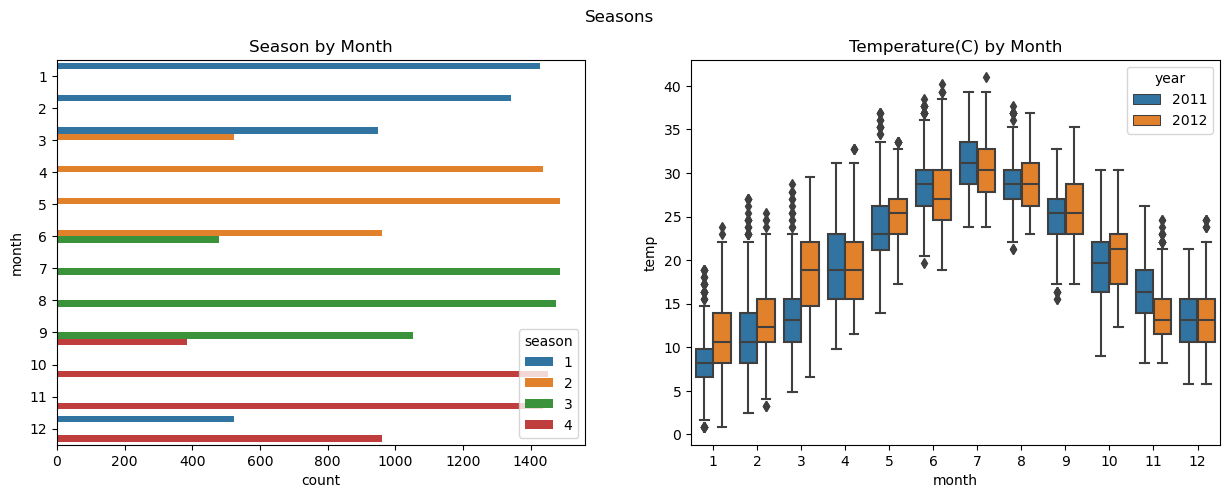

In [23]:
#visualizing season by month, temperature by month
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=False, sharex=False)
fig.suptitle('Seasons')

# Season by Month
sns.countplot(ax=axes[0], data = df_full, y = 'month', hue = 'season')
axes[0].set_title('Season by Month')

# Temperature by Month
sns.boxplot(ax=axes[1], data = df_full, x = 'month', y = 'temp', hue = 'year')
axes[1].set_title('Temperature(C) by Month');

<br>

##### 2. How do weather conditions impact bike rentals?

The graphs below show the highest number of rentals in weather label 1 for both years and the least in labels 3 & 4. Based on this data, we can conclude that the more pleasant the weather, the higher the bike rentals.

**Weather labels**:
- 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

In [24]:
#compute new columns: year, month, day & hour
df['year'] = df.datetime.dt.year
df['month'] = df.datetime.dt.month
df['day'] = df.datetime.dt.day
df['hour'] = df.datetime.dt.hour

#select 2011 and 2012 data and save them as separate dfs
twenty_11 = df[df['year'] == 2011]
twenty_12 = df[df['year'] == 2012]

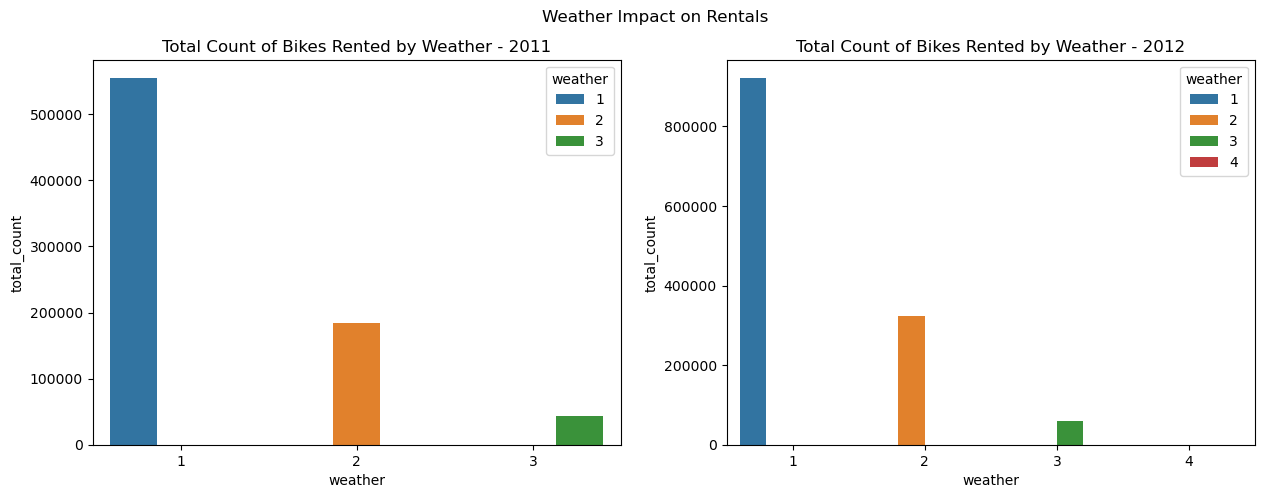

In [25]:
#visualizing total count of bike rentals by weather: 2011, 2012
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=False, sharex=False)
fig.suptitle('Weather Impact on Rentals')

#2011
count_byweather = twenty_11['count'].groupby(twenty_11['weather']).sum()
count_byweather_df = pd.DataFrame({'weather': count_byweather.index, 'total_count': count_byweather.values})
sns.barplot(ax=axes[0], data=count_byweather_df, x = 'weather', y= 'total_count', hue='weather')
axes[0].set_title('Total Count of Bikes Rented by Weather - 2011')

#2012
count_byweather = twenty_12['count'].groupby(twenty_12['weather']).sum()
count_byweather_df = pd.DataFrame({'weather': count_byweather.index, 'total_count': count_byweather.values})
sns.barplot(ax=axes[1], data=count_byweather_df, x = 'weather', y= 'total_count', hue='weather')
axes[1].set_title('Total Count of Bikes Rented by Weather - 2012');

<br>

##### 3. What is the rental trend across years, months, days & hours?

Below, we see that:

- the first graph show that there were generally more rentals in 2012 than in 2011
- the next set of 2 graphs zoom in on each year's trend:
    - the mid-months(5th through 9th) recorded the highest rentals in both years
    - the lowest rentals are recorded in the winter months(1st - 3rd) 
    - rentals gradually increase into the spring and summer months, and begins to fall in the fall months
- the third & fourth set of graphs show rental trend across days in each month of 2011 & 2012 respectively:
    - In 2011, there are higher rentals in months 4 - 12 than in months 1, 2 & 3
    - In 2012, there are higher rentals in months 3 - 10 than in months 11 & 12, and 1 & 2
- the final graph shows that the highest number of rentals are recorded in the evening between the 16th & 19th hour while the least rentals are recorded in the early hours of the morning, between the 1st & 5th hour

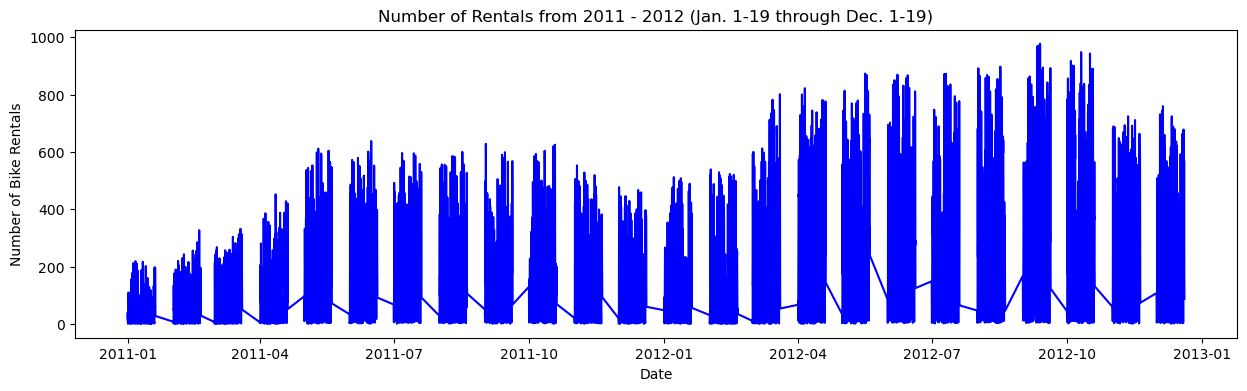

In [26]:
#visualizing rental trend in df
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Number of Bike Rentals', dpi=100):
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.plot(x, y, color='blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
    

plot_df(df, x=df['datetime'], y=df['count'], title='Number of Rentals from 2011 - 2012 (Jan. 1-19 through Dec. 1-19)')

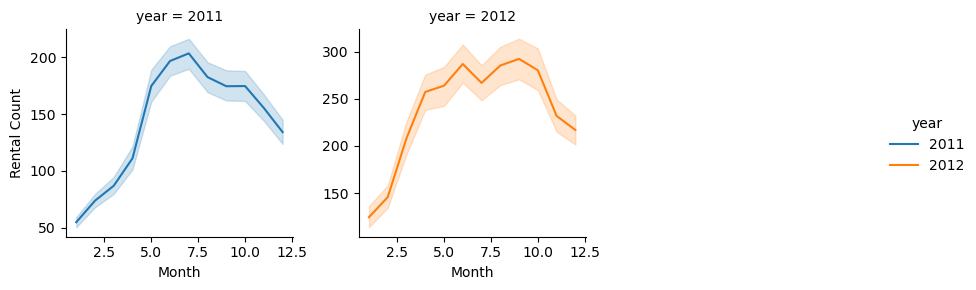

In [27]:
#visualizing rental trend in each year: 2011, 2012
Count_facegrid = sns.FacetGrid(df, col= "year", col_wrap=3,
                               hue = "year", sharey = False, sharex = False)

Count_facegrid = (Count_facegrid.map(sns.lineplot, "month", "count")
                  .add_legend()
                  .set_axis_labels("Month","Rental Count"))

Count_facegrid;

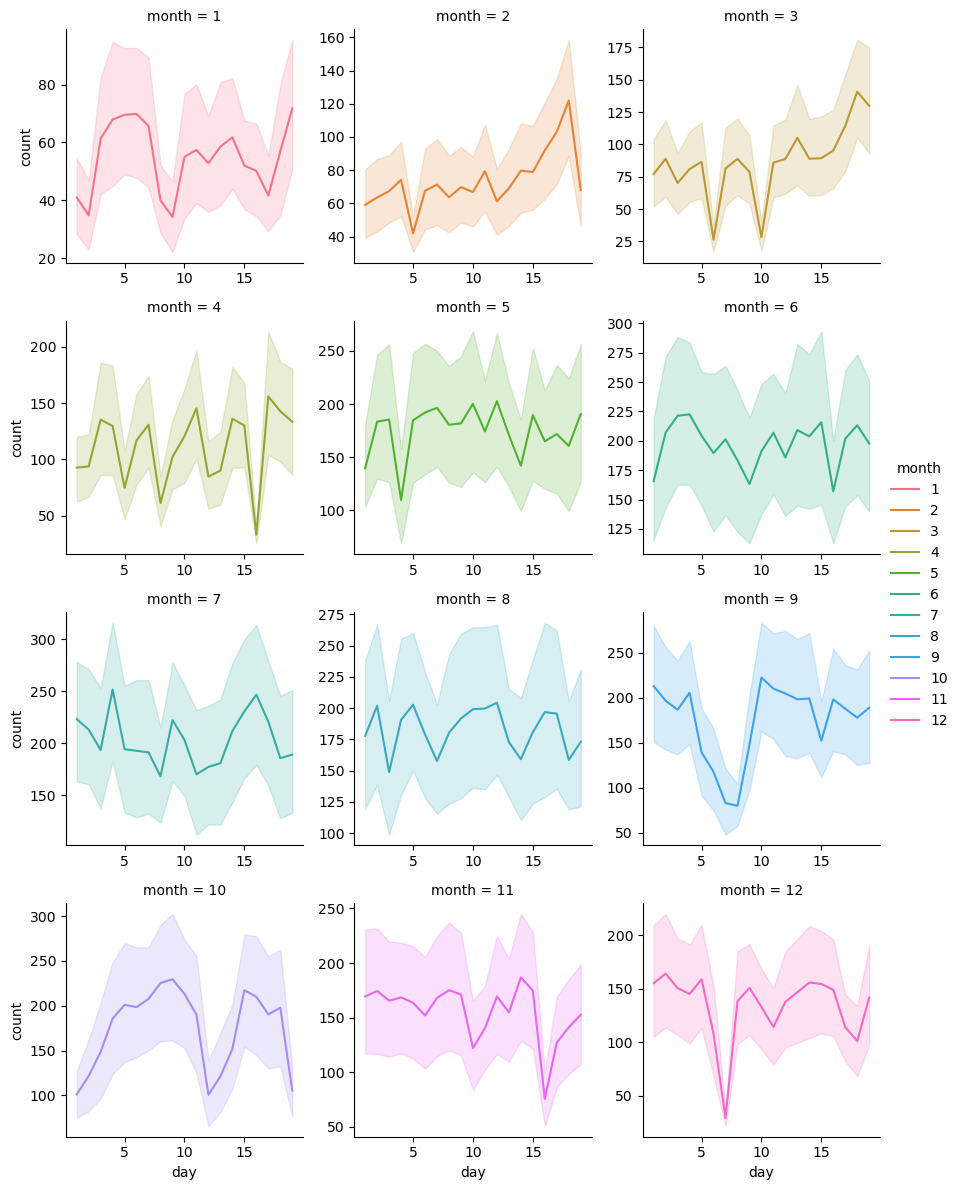

In [28]:
#visualizing rental trend in each month of 2011
rentalcount_2011 = sns.FacetGrid(twenty_11, col= "month", col_wrap=3,
                               hue = "month", sharey = False, sharex = False)

rentalcount_2011 = (rentalcount_2011.map(sns.lineplot, "day", "count")
                  .add_legend()
                  .set_axis_labels("day","count"))

rentalcount_2011;

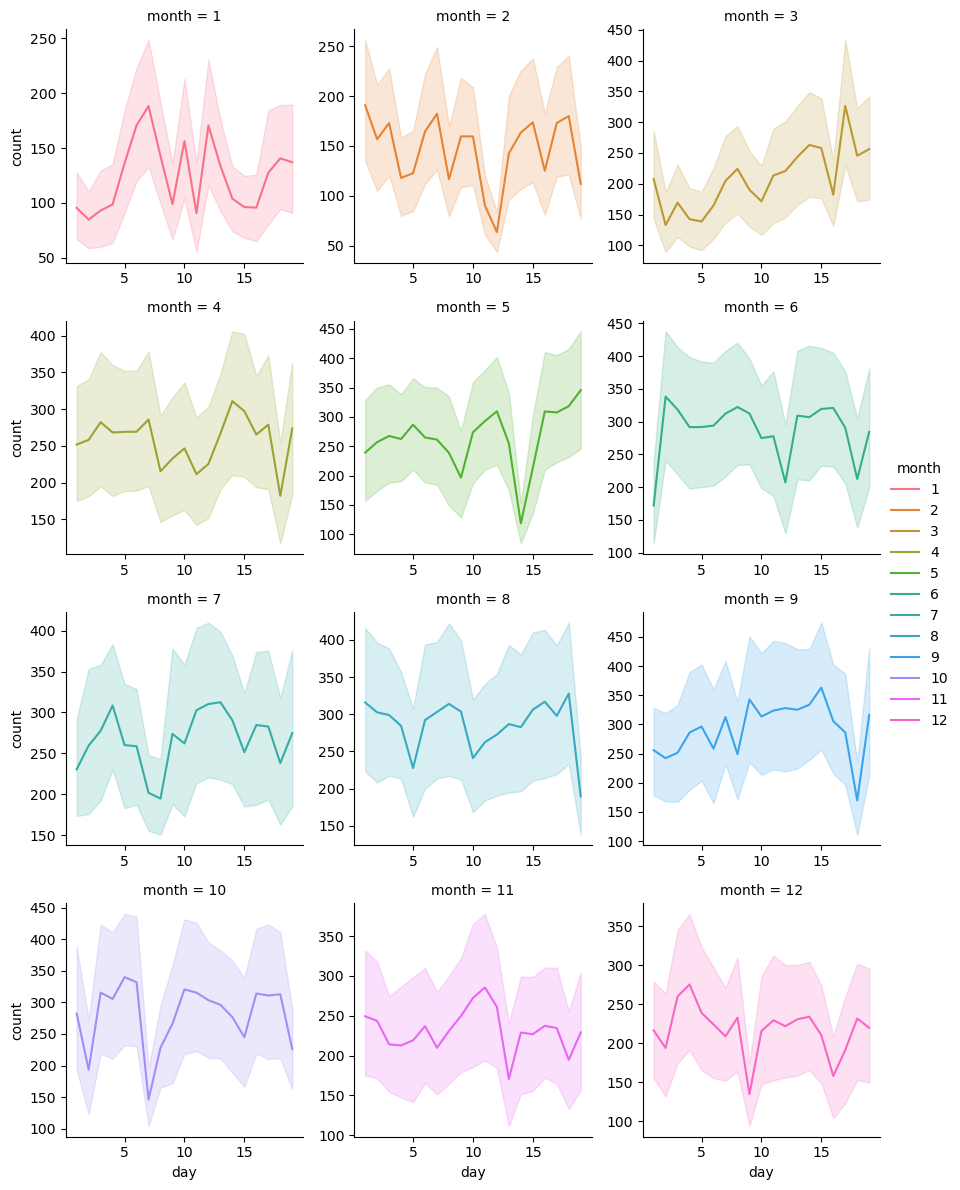

In [29]:
#visualizing rental trend in each month of 2012
rentalcount_2012 = sns.FacetGrid(twenty_12, col= "month", col_wrap=3,
                               hue = "month", sharey = False, sharex = False)

rentalcount_2012 = (rentalcount_2012.map(sns.lineplot, "day", "count")
                  .add_legend()
                  .set_axis_labels("day","count"))

rentalcount_2012;

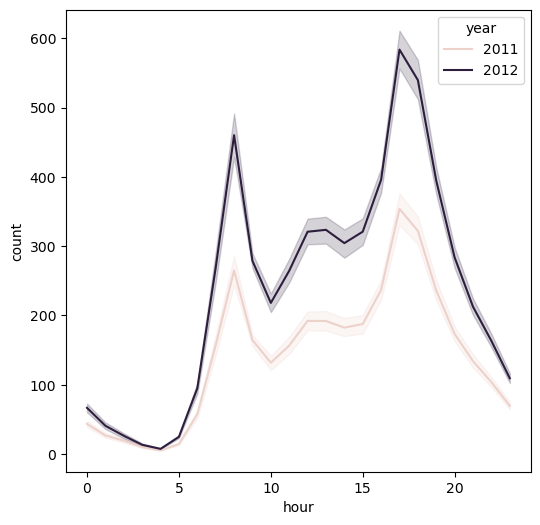

In [30]:
#visualizing rental trend by hour in 2011 & 2012
sns.lineplot(data=df, x = 'hour', y = 'count', hue = 'year', markers=True);

<br>

##### 4. What is the correlation between target variable `count` and the other variables?

- **registered**:    0.970948
- **casual**:        0.690414
- **hour**:          0.400601
- **temp**:          0.394454
- **atemp**:         0.389784
- **year**:          0.260403
- **month**:         0.166862
- **season**:        0.163439
- **windspeed**:     0.101369
- **day**:           0.019826
- **workingday**:    0.011594
- **holiday**:      -0.005393
- **weather**:      -0.128655
- **humidity**:     -0.317371

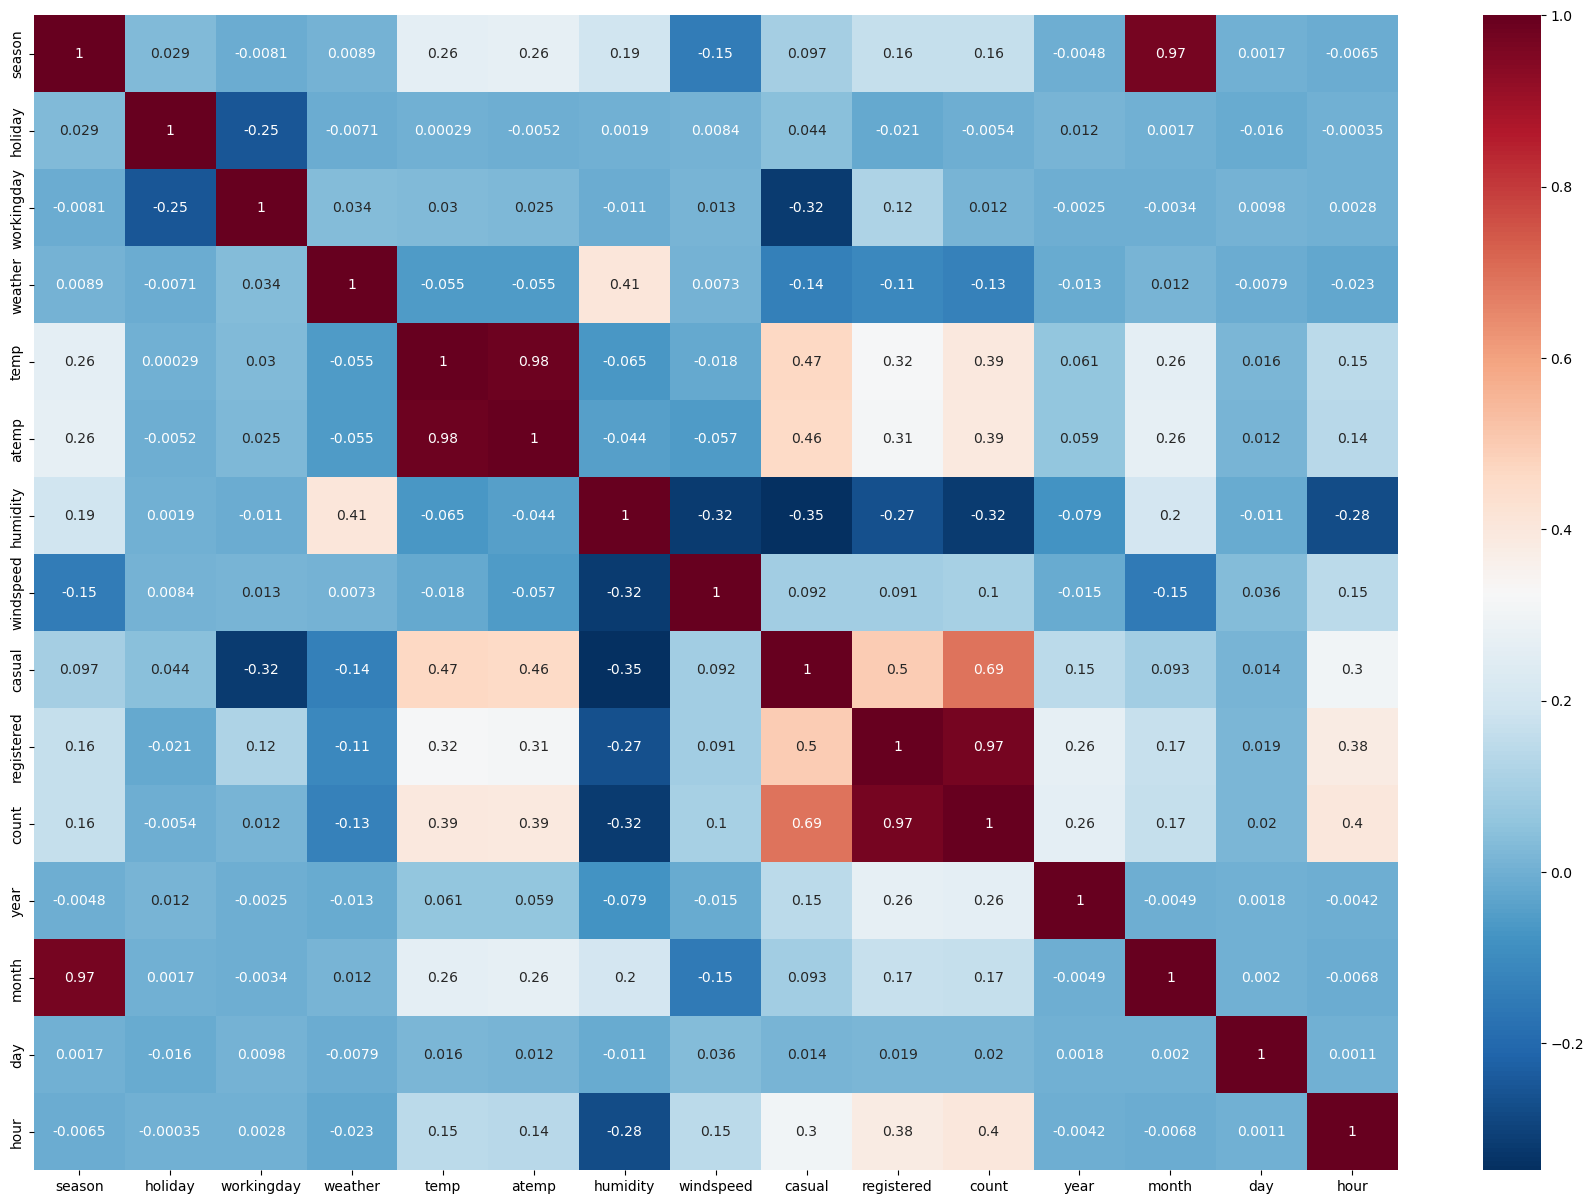

<Figure size 600x600 with 0 Axes>

In [31]:
#visualizing correlation matrix
corr_matrix = df.corr(method='pearson')
plt.figure(figsize = (22,15))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r')
plt.show()
plt.clf()

In [32]:
#correlation between features: > 0.4
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.4:
            print(corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j])

atemp temp 0.9849481104817075
humidity weather 0.4062436513120954
casual temp 0.46709706412013263
casual atemp 0.46206653642600143
registered casual 0.49724968508700884
count casual 0.6904135653286754
count registered 0.9709481058098266
month season 0.9715237996323898
hour count 0.40060119414684714


In [33]:
#correlation between count and other variables
corr_matrix['count'].sort_values(ascending=False)

count         1.000000
registered    0.970948
casual        0.690414
hour          0.400601
temp          0.394454
atemp         0.389784
year          0.260403
month         0.166862
season        0.163439
windspeed     0.101369
day           0.019826
workingday    0.011594
holiday      -0.005393
weather      -0.128655
humidity     -0.317371
Name: count, dtype: float64

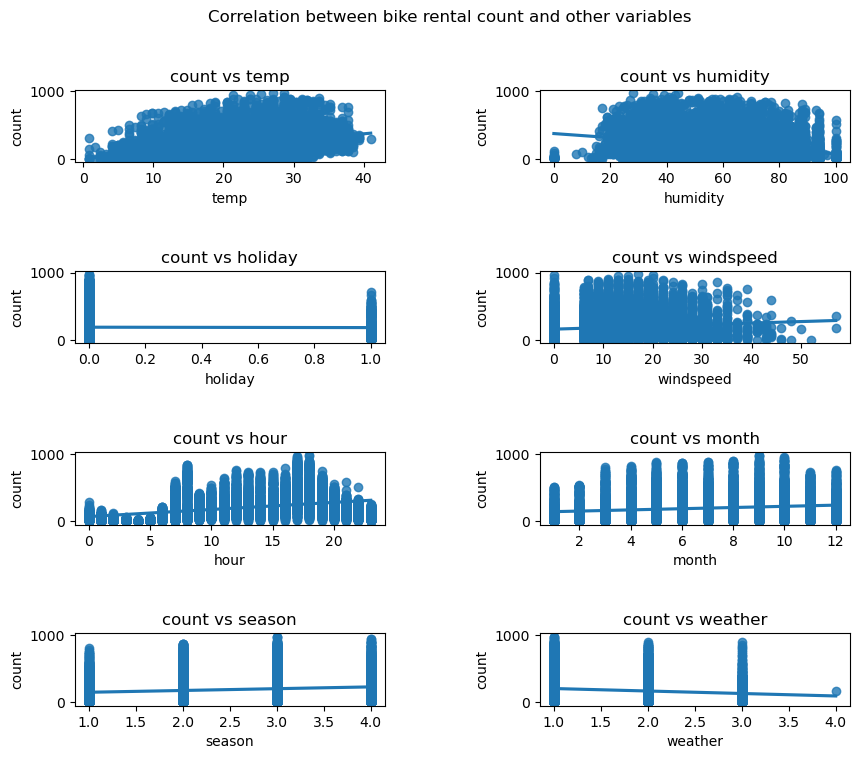

In [34]:
#visualizing correlation between count and some of the other variables
fig, axes = plt.subplots(4, 2, figsize=(10, 8))
fig.suptitle('Correlation between bike rental count and other variables')

fig.subplots_adjust(hspace=1.5, wspace=0.5)

sns.regplot(ax=axes[0, 0], data = df, x = 'temp', y = 'count')
axes[0, 0].set_title('count vs temp')

sns.regplot(ax=axes[0, 1], data = df, x = 'humidity', y = 'count')
axes[0, 1].set_title('count vs humidity')

sns.regplot(ax=axes[1, 0], data = df, x = 'holiday', y = 'count')
axes[1, 0].set_title('count vs holiday')

sns.regplot(ax=axes[1, 1], data = df, x = 'windspeed', y = 'count')
axes[1, 1].set_title('count vs windspeed')

sns.regplot(ax=axes[2, 0], data = df, x = 'hour', y = 'count')
axes[2, 0].set_title('count vs hour')

sns.regplot(ax=axes[2, 1], data = df, x = 'month', y = 'count')
axes[2, 1].set_title('count vs month')

sns.regplot(ax=axes[3, 0], data = df, x = 'season', y = 'count')
axes[3, 0].set_title('count vs season')

sns.regplot(ax=axes[3, 1], data = df, x = 'weather', y = 'count')
axes[3, 1].set_title('count vs weather');

<br>

### Data Preprocessing

- first, the `casual` & `registered` columns are dropped as they are not included in the `prediction_df`
- the `day` column are removed from both dataframes as there are different days in both data
- columns with categorical variables are converted into dummy variables using `pd.get_dummies`

In [35]:
#make a copy of df
df_copy = df.copy()

#drop datetime, casual & registered columns
df_copy = df_copy.drop(columns= ['datetime', 'casual', 'registered', 'day'], axis =1)

In [36]:
#convert categorical variables into dummy variables
df_copy = pd.get_dummies(df_copy, columns=['season', 'holiday', 'workingday', 'weather', 'year', 'month', 'hour'])

In [37]:
#check non-null values and datatypes in df_copy
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 55 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   temp          10886 non-null  float64
 1   atemp         10886 non-null  float64
 2   humidity      10886 non-null  int64  
 3   windspeed     10886 non-null  float64
 4   count         10886 non-null  int64  
 5   season_1      10886 non-null  uint8  
 6   season_2      10886 non-null  uint8  
 7   season_3      10886 non-null  uint8  
 8   season_4      10886 non-null  uint8  
 9   holiday_0     10886 non-null  uint8  
 10  holiday_1     10886 non-null  uint8  
 11  workingday_0  10886 non-null  uint8  
 12  workingday_1  10886 non-null  uint8  
 13  weather_1     10886 non-null  uint8  
 14  weather_2     10886 non-null  uint8  
 15  weather_3     10886 non-null  uint8  
 16  weather_4     10886 non-null  uint8  
 17  year_2011     10886 non-null  uint8  
 18  year_2012     10886 non-nu

In [38]:
#make a copy of prediction_df
prediction_dfcopy = prediction_df.copy()

#compute new columns: year, moth, day & hour
prediction_dfcopy['year'] = prediction_dfcopy.datetime.dt.year
prediction_dfcopy['month'] = prediction_dfcopy.datetime.dt.month
prediction_dfcopy['day'] = prediction_dfcopy.datetime.dt.day
prediction_dfcopy['hour'] = prediction_dfcopy.datetime.dt.hour

#drop datetime & day columns
prediction_dfcopy = prediction_dfcopy.drop(columns= ['datetime', 'day'], axis =1)

In [39]:
#convert categorical variables into dummy variables
prediction_dfcopy = pd.get_dummies(prediction_dfcopy, columns=['season', 'holiday', 'workingday', 'weather', 'year', 'month', 'hour'])

In [40]:
#check non-null values and datatypes in df_copy
prediction_dfcopy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 54 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   temp          6493 non-null   float64
 1   atemp         6493 non-null   float64
 2   humidity      6493 non-null   int64  
 3   windspeed     6493 non-null   float64
 4   season_1      6493 non-null   uint8  
 5   season_2      6493 non-null   uint8  
 6   season_3      6493 non-null   uint8  
 7   season_4      6493 non-null   uint8  
 8   holiday_0     6493 non-null   uint8  
 9   holiday_1     6493 non-null   uint8  
 10  workingday_0  6493 non-null   uint8  
 11  workingday_1  6493 non-null   uint8  
 12  weather_1     6493 non-null   uint8  
 13  weather_2     6493 non-null   uint8  
 14  weather_3     6493 non-null   uint8  
 15  weather_4     6493 non-null   uint8  
 16  year_2011     6493 non-null   uint8  
 17  year_2012     6493 non-null   uint8  
 18  month_1       6493 non-null 

<br>

### Machine Learning Modeling & Evaluation

**Linear Regression**

After fitting training data and evaluating on test data, the three linear regression models created below are averaging 
- 0.69 in `R^2` 
- ~101.8 in `RMSE`

In [41]:
# take a list of features to model as a parameter
def model_these_features(feature_list):
    
    #Define features and target
    feature = df_copy.loc[:, feature_list]
    target = df_copy['count']
    
    #Split Data into training and test sets
    feature_train, feature_val, target_train, target_val = train_test_split(feature, target, test_size = 0.3, random_state = 1)

    #Allow the model to work when we model on just one feature instead of multiple features
    if len(feature_train.shape) < 2:
        feature_train = np.array(feature_train).reshape(-1,1)
        feature_val = np.array(feature_val).reshape(-1,1)
    
    #standardize data
    scaler = StandardScaler()
    feature_train = scaler.fit_transform(feature_train)
    feature_val = scaler.transform(feature_val)
    
    #Create and train the model
    model = LinearRegression()
    model.fit(feature_train, target_train)
    
    # print the model features and their corresponding coefficients, from most predictive to least predictive
    # print(sorted(list(zip(feature_list, model.coef_)),key = lambda x: abs(x[1]),reverse=True))
    
    #predict target
    rentalcount_predicted = model.predict(feature_val)
    
    #print RMSE, training & test scores
    print('Train Score, R^2: %.2f:', model.score(feature_train, target_train))
    print('Test Score, R^2: %.2f:', model.score(feature_val, target_val))
    print('RMSE: %.2f' % sqrt(mean_squared_error(target_val, rentalcount_predicted)))
    
    #Visualize Predicted target vs actual target!
    plt.scatter(target_val, rentalcount_predicted)
    plt.xlabel('Actual Rental Count')
    plt.ylabel('Predicted Rental Count')
    plt.show()

In [42]:
#subset of all features
all_features = ['temp', 'atemp', 'humidity', 'windspeed', 'season_1', 
                'season_2', 'season_3', 'season_4', 'holiday_0', 'holiday_1',
                'workingday_0', 'workingday_1', 'weather_1', 'weather_2', 'weather_3',
                'weather_4', 'year_2011', 'year_2012', 'month_1', 'month_2', 'month_3',
                'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
                'month_10', 'month_11', 'month_12', 'hour_0', 'hour_1', 'hour_2',
                'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
                'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
                'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
                'hour_22', 'hour_23']

#all features without windspeed & workingday
fewer_features = ['temp', 'atemp', 'humidity', 'season_1', 'season_2',
                 'season_3', 'season_4', 'holiday_0', 'holiday_1', 'weather_1', 
                 'weather_2', 'weather_3', 'weather_4', 'year_2011', 'year_2012', 
                 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 
                 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 
                 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 
                 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10',
                 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16',
                 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22',
                 'hour_23']


#all features without atemp
selected_features = ['temp', 'humidity', 'windspeed', 'season_1', 'season_2',
                    'season_3', 'season_4', 'holiday_0', 'holiday_1', 'workingday_0',
                    'workingday_1', 'weather_1', 'weather_2', 'weather_3', 'weather_4',
                    'year_2011', 'year_2012', 'month_1', 'month_2', 'month_3', 'month_4',
                    'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
                    'month_11', 'month_12', 'hour_0', 'hour_1', 'hour_2', 'hour_3',
                    'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10',
                    'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16',
                    'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22',
                    'hour_23']

Train Score, R^2: %.2f: 0.6928690167705301
Test Score, R^2: %.2f: 0.6930544068271057
RMSE: 101.75


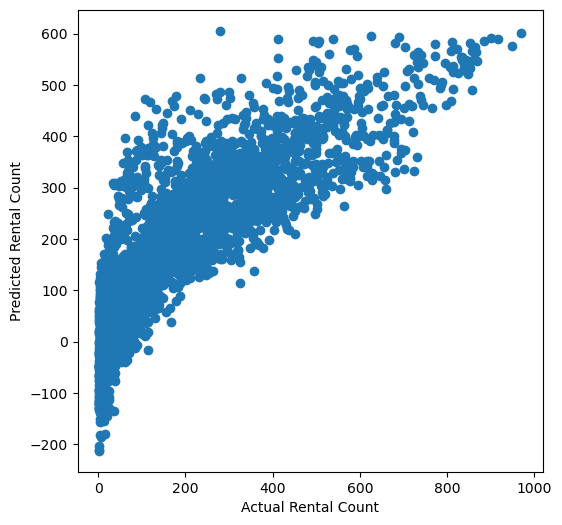

In [43]:
#fit & evaluate all features
model_these_features(all_features)

Train Score, R^2: %.2f: 0.6921124003832775
Test Score, R^2: %.2f: 0.6928517468348373
RMSE: 101.78


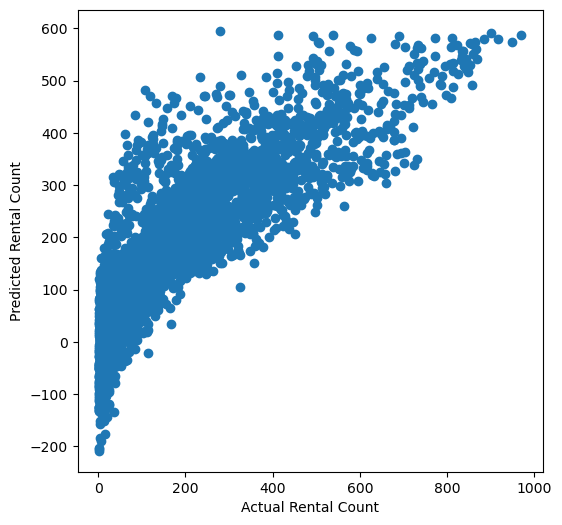

In [44]:
#fit & evaluate fewer_features
model_these_features(fewer_features)

Train Score, R^2: %.2f: 0.6914859689031321
Test Score, R^2: %.2f: 0.6914112879021841
RMSE: 102.02


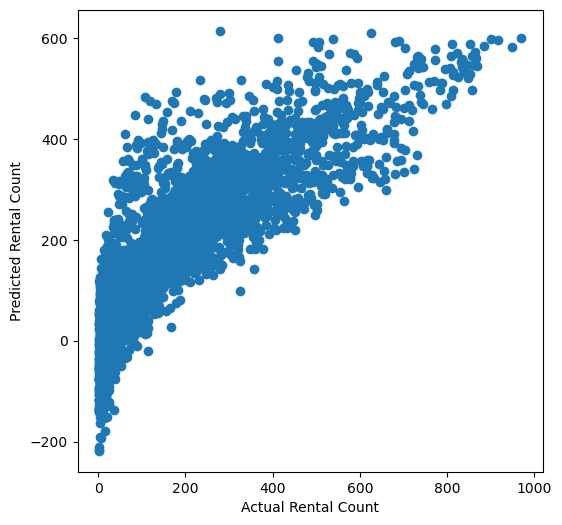

In [45]:
#fit & evaluate selected_features
model_these_features(selected_features)

<br>

**Random Forest Regression**

After looping through a range of depths, a `best_rfr` model was fitted to training data using the best depth. The evaluation results are much better than that of the Linear regression models:

- **Train set**: R^2 - 0.987, MAE - ~13
- **Test set**: R^2 - 0.917, MAE - ~35
- **RMSE**: 52.80

In [46]:
#Define features and target
feature = df_copy.drop(columns= ['count'])
target = df_copy['count']
    
#Split Data into training and test sets
feature_train, feature_val, target_train, target_val = train_test_split(feature, target, test_size = 0.3, random_state = 1)

#standardize data
scaler = StandardScaler()
feature_train = scaler.fit_transform(feature_train)
feature_val = scaler.transform(feature_val)

In [47]:
#loop through a range of depths to find the best max_depth for a RFReg model
accuracy_train=[]
accuracy_test = []
depths = range(1,50)
for i in depths:
    rfr = RandomForestRegressor(max_depth=i)
    rfr.fit(feature_train, target_train)
    rentalcount_predicted = rfr.predict(feature_val)
    accuracy_test.append(rfr.score(feature_val, target_val))
    accuracy_train.append(rfr.score(feature_train, target_train))
    
best_acc= np.max(accuracy_test)
best_depth = depths[np.argmax(accuracy_test)]
print(f'The highest accuracy on the test is achieved when depth: {best_depth}')
print(f'The highest accuracy on the test set is: {round(best_acc*100,3)}%')

The highest accuracy on the test is achieved when depth: 34
The highest accuracy on the test set is: 91.948%


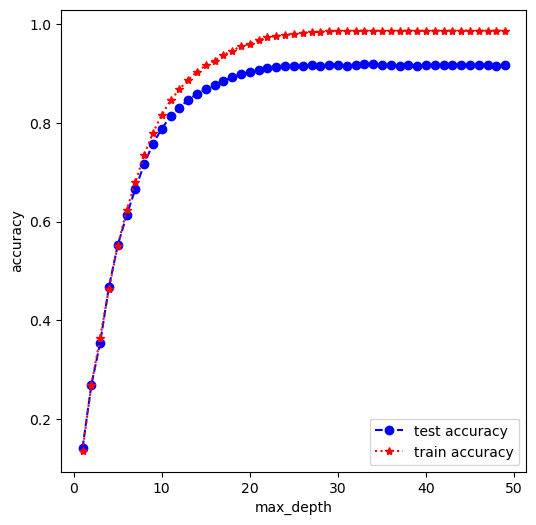

In [48]:
#plot accuracy vs. max_depth
plt.figure(2)
plt.plot(depths, accuracy_test,'bo--',depths, accuracy_train,'r*:')
plt.legend(['test accuracy', 'train accuracy'])
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.show()

In [49]:
#fit training data using the best max_depth
best_rfr = RandomForestRegressor(max_depth=best_depth)
best_rfr.fit(feature_train, target_train)

#predict target
rentalcount_predicted = best_rfr.predict(feature_val)

#print out first 30 random forest features in order of importance
feature_imp_df = pd.DataFrame(zip(df_copy.drop(columns= ['count']), best_rfr.feature_importances_),  columns=['feature', 'importance'])
print('By Importance - Top 30 random forest features:')
print(feature_imp_df.sort_values('importance', ascending=False).iloc[0:30])

By Importance - Top 30 random forest features:
         feature  importance
1          atemp    0.147197
47       hour_17    0.096338
48       hour_18    0.080300
2       humidity    0.079998
38        hour_8    0.061803
10  workingday_0    0.048549
11  workingday_1    0.048536
0           temp    0.044556
17     year_2012    0.041166
16     year_2011    0.037487
49       hour_19    0.028502
4       season_1    0.019372
32        hour_2    0.018231
31        hour_1    0.016840
34        hour_4    0.016342
3      windspeed    0.016252
33        hour_3    0.016126
30        hour_0    0.015842
37        hour_7    0.015417
35        hour_5    0.014379
46       hour_16    0.013385
14     weather_3    0.011028
53       hour_23    0.010943
50       hour_20    0.010701
39        hour_9    0.009734
36        hour_6    0.009185
7       season_4    0.007384
52       hour_22    0.005982
51       hour_21    0.004604
40       hour_10    0.004463


In [50]:
#evaluation metrics
print(f'Train set R^2: {np.round(best_rfr.score(feature_train, target_train), 3)}')
print(f'Test set R^2: {np.round(best_rfr.score(feature_val, target_val), 3)}')
print('RMSE: %.2f' % sqrt(mean_squared_error(target_val, rentalcount_predicted)))
print(f'Train set MAE: {np.round(mean_absolute_error(target_train, best_rfr.predict(feature_train)), 2)}')
print(f'Test set MAE: {np.round(mean_absolute_error(target_val, rentalcount_predicted), 2)}')

Train set R^2: 0.987
Test set R^2: 0.917
RMSE: 52.80
Train set MAE: 13.09
Test set MAE: 34.82


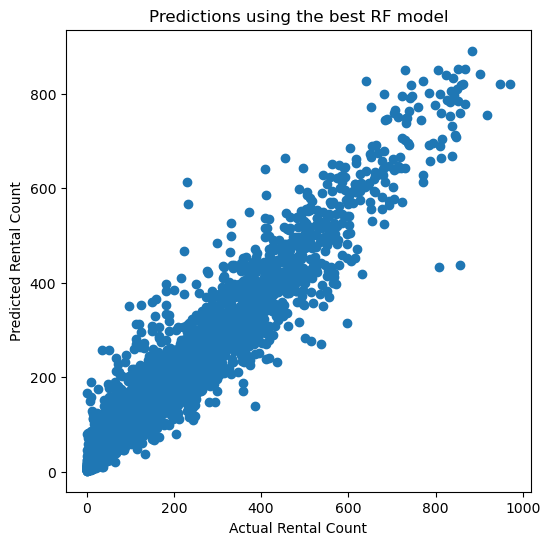

In [51]:
#Visualize Predicted target vs actual target!
plt.scatter(target_val, rentalcount_predicted)
plt.xlabel('Actual Rental Count')
plt.ylabel('Predicted Rental Count')
plt.title('Predictions using the best RF model')
plt.show()

<br>

**K-Nearest Neighbors**

After looping through a range of n_neighbors (k), a `best_knn` model was fitted to training data using the best k. 
Using the evaluation metrics, here are the results:

- **Train set**: R^2 - 1.0, MAE - 0.07
- **Test set**: R^2 - 0.887, MAE - ~39
- **RMSE**: 63.42

In [58]:
#loop through a range of n_neighbors to find the best k for a KNN Reg model
accuracy_train=[]
accuracy_test = []
n_neighbors = range(1,50)
for i in n_neighbors:
    knn = KNeighborsRegressor(n_neighbors=i, weights='distance')
    knn.fit(feature_train, target_train)
    rentalcount_predicted = knn.predict(feature_val)
    accuracy_test.append(knn.score(feature_val, target_val))
    accuracy_train.append(knn.score(feature_train, target_train))
    
best_acc= np.max(accuracy_test)
best_nneighbors = n_neighbors[np.argmax(accuracy_test)]
print(f'The highest accuracy on the test is achieved when n_neighor: {best_nneighbors}')
print(f'The highest accuracy on the test set is: {round(best_acc*100,3)}%')

The highest accuracy on the test is achieved when n_neighor: 3
The highest accuracy on the test set is: 88.726%


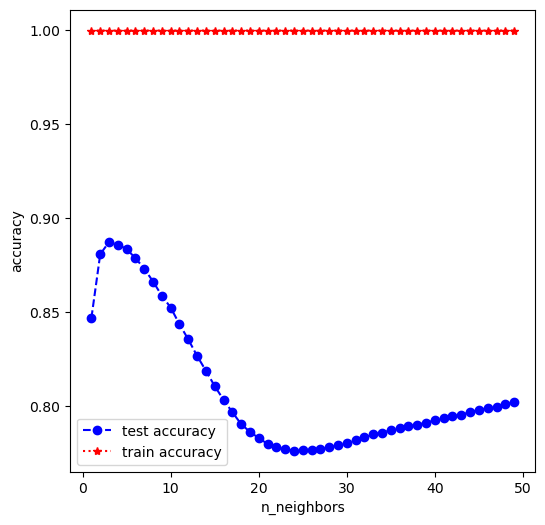

In [59]:
#plot accuracy vs. n_neighbors
plt.figure(2)
plt.plot(n_neighbors, accuracy_test,'bo--', n_neighbors, accuracy_train,'r*:')
plt.legend(['test accuracy', 'train accuracy'])
plt.xlabel('n_neighbors')
plt.ylabel('accuracy')
plt.show()

In [60]:
#fit training data using the best k
best_knn = KNeighborsRegressor(n_neighbors=best_nneighbors, weights='distance')
best_knn.fit(feature_train, target_train)

#predict target
rentalcount_predicted = best_knn.predict(feature_val)

In [61]:
#evaluation metrics
print(f'Train set R^2: {np.round(best_knn.score(feature_train, target_train), 3)}')
print(f'Test set R^2: {np.round(best_knn.score(feature_val, target_val), 3)}')
print('RMSE: %.2f' % sqrt(mean_squared_error(target_val, rentalcount_predicted)))
print(f'Train set MAE: {np.round(mean_absolute_error(target_train, best_knn.predict(feature_train)), 2)}')
print(f'Test set MAE: {np.round(mean_absolute_error(target_val, rentalcount_predicted), 2)}')

Train set R^2: 1.0
Test set R^2: 0.887
RMSE: 61.66
Train set MAE: 0.06
Test set MAE: 38.21


<br>

**Auto Gluon**

- **Best Model**: WeightedEnsemble_L3
- **Test score**: 0.978
- **RMSE**: 41.387

In [62]:
#hyperparameters
num_trials = 5
search_strategy = 'auto'
hyperparameter_tune_kwargs = {'num_trials': num_trials, 'scheduler': 'local', 'searcher': search_strategy}

#fit autogluon
predictor = TabularPredictor(label='count', problem_type='regression', eval_metric='root_mean_squared_error').fit(train_data=df_copy, time_limit=600, presets='best_quality', hyperparameter_tune_kwargs=hyperparameter_tune_kwargs)

No model was trained during hyperparameter tuning NeuralNetTorch_BAG_L2... Skipping this model.
Fitting model: LightGBMLarge_BAG_L2 ... Training model for up to 19.79s of the -131.53s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	-42.5145	 = Validation score   (-root_mean_squared_error)
	36.05s	 = Training   runtime
	0.27s	 = Validation runtime
Completed 1/20 k-fold bagging repeats ...
Fitting model: WeightedEnsemble_L3 ... Training model for up to 360.0s of the -172.26s of remaining time.
	-41.3865	 = Validation score   (-root_mean_squared_error)
	0.56s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 773.06s ... Best model: "WeightedEnsemble_L3"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20230901_203545/")


In [63]:
# predictor.fit_summary()

In [64]:
#evaluation metrics
predictor.leaderboard(df_copy, extra_metrics=['mean_squared_error', 'mean_absolute_error', 'r2', 'pearsonr'], silent=True)

,model,score_test,mean_squared_error,mean_absolute_error,r2,pearsonr,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,ExtraTreesMSE_BAG_L1,-16.985040,-288.491594,-10.625091,0.991207,0.995773,-45.904312,2.112154,0.000188,18.828659,2.112154,0.000188,18.828659,1,True,7
1,RandomForestMSE_BAG_L1,-18.065907,-326.377007,-11.587196,0.990053,0.995267,-48.738095,1.893168,0.000169,28.041445,1.893168,0.000169,28.041445,1,True,5
2,LightGBMLarge_BAG_L1,-20.874090,-435.727652,-14.525020,0.986720,0.993456,-43.919386,12.459710,1.764630,43.369960,12.459710,1.764630,43.369960,1,True,9
3,XGBoost_BAG_L1/T1,-24.073632,-579.539735,-16.624577,0.982337,0.991270,-46.425588,5.549673,0.000140,40.371308,5.549673,0.000140,40.371308,1,True,8
4,CatBoost_BAG_L2/T1,-25.864843,-668.990089,-16.922374,0.979610,0.989785,-42.065782,54.701778,1.766208,288.441996,0.184813,0.000123,28.707314,2,True,14
5,LightGBMXT_BAG_L2/T1,-26.099271,-681.171961,-16.682293,0.979239,0.989580,-42.284941,57.648282,1.767291,288.939118,3.131317,0.001207,29.204436,2,True,11
6,WeightedEnsemble_L3,-26.660044,-710.757947,-16.643688,0.978337,0.989158,-41.386527,62.989777,2.035326,412.094333,0.028462,0.000854,0.563135,3,True,18
7,WeightedEnsemble_L2,-27.067109,-732.628375,-18.061366,0.977671,0.988909,-41.678969,46.736802,1.766469,190.645119,0.009884,0.001107,0.798147,2,True,10
8,ExtraTreesMSE_BAG_L2,-27.458297,-753.958063,-16.799909,0.977021,0.988485,-41.587759,56.414168,1.766258,287.788396,1.897203,0.000174,28.053715,2,True,15
9,LightGBM_BAG_L2/T1,-27.568962,-760.047686,-17.685514,0.976835,0.988466,-42.067248,55.468896,1.767968,289.511174,0.951931,0.001883,29.776492,2,True,12


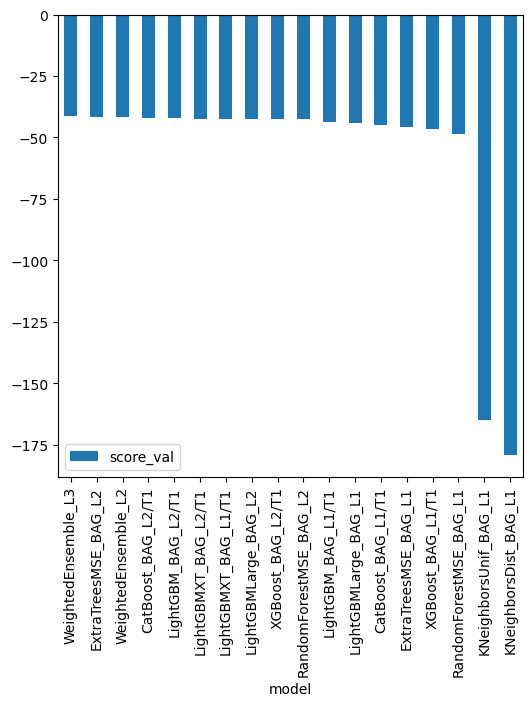

In [65]:
#visualize RMSE vs AutoGluon models
predictor.leaderboard(silent=True).plot(kind='bar', x='model', y='score_val');

<br>

### Conclusion

The graphs below show that out of all the four models, AutoGluon's `WeightedEnsemble_L3` has the highest test score & lowest RMSE value. **Let's predict!**

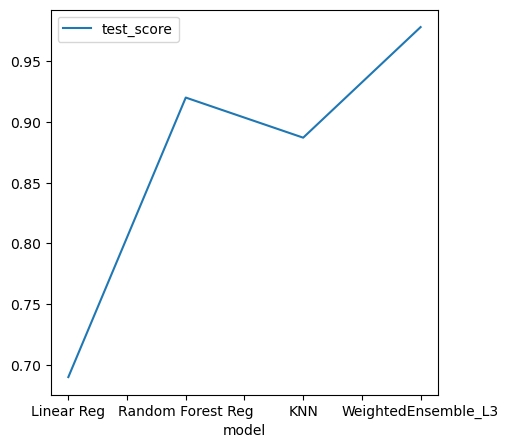

In [66]:
#visualize test scores of "Linear Reg", "Random Forest Reg", "KNN", and 'WeightedEnsemble_L3'(from AutoGluon)
fig = pd.DataFrame(
    {
        "model": ["Linear Reg", "Random Forest Reg", "KNN", 'WeightedEnsemble_L3'],
        "test_score": [0.69, 0.92, 0.887, 0.978]
    }
).plot(x="model", y="test_score", figsize=(5, 5)).get_figure()
# fig.savefig('model_test_score.png')

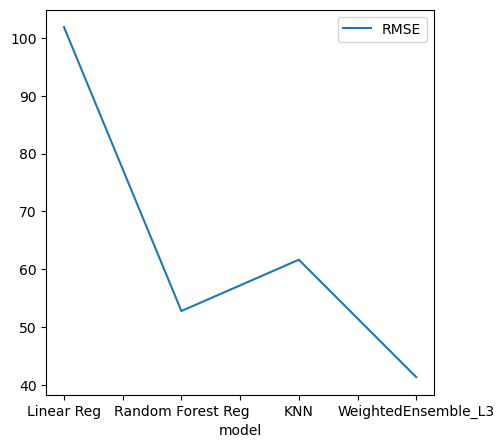

In [67]:
#visualize RMSE of "Linear Reg", "Random Forest Reg", "KNN", and 'WeightedEnsemble_L3'(from AutoGluon)
fig = pd.DataFrame(
    {
        "model": ["Linear Reg", "Random Forest Reg", "KNN", 'WeightedEnsemble_L3'],
        "RMSE": [101.85, 52.80, 61.66, 41.387]
    }
).plot(x="model", y="RMSE", figsize=(5, 5)).get_figure()
# fig.savefig('model_test_score.png')

<br>

### Predicting on new data 

Predict target using `WeightedEnsemble L3`

In [68]:
#make predictions on new data: prediction_dfcopy
submission['count'] = predictor.predict(prediction_dfcopy)

In [69]:
#convert target, 'count', column to int64
submission['count'] = submission['count'].astype('int64')
submission['count']

0        10
1         5
2         4
3         4
4         3
       ... 
6488    241
6489    157
6490    135
6491     98
6492     57
Name: count, Length: 6493, dtype: int64

In [70]:
#save predictions as a csv file
submission.to_csv("submission.csv", index=False, header=True)

<br>

**The predicted data graph below reflects similar rental trend as our train data:**

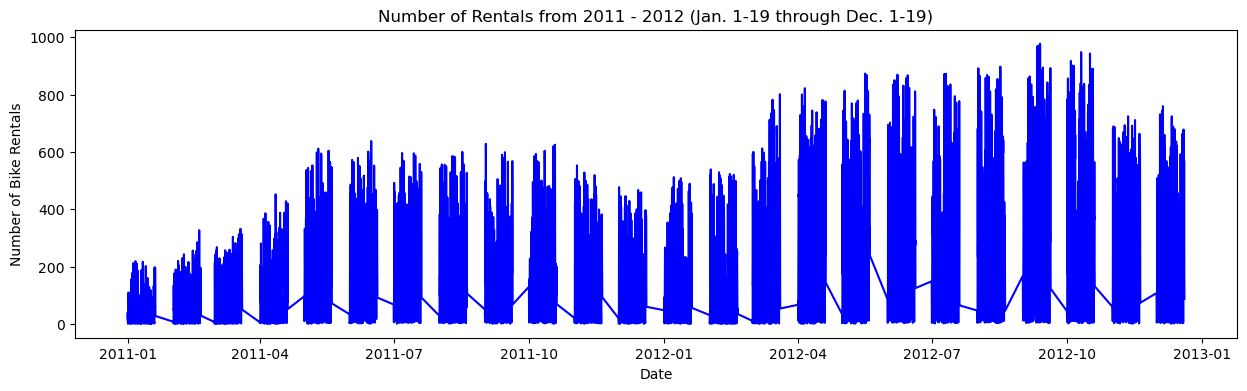

In [71]:
#Visualing train data: count vs datetime 
plot_df(df, x=df['datetime'], y=df['count'], title='Number of Rentals from 2011 - 2012 (Jan. 1-19 through Dec. 1-19)')

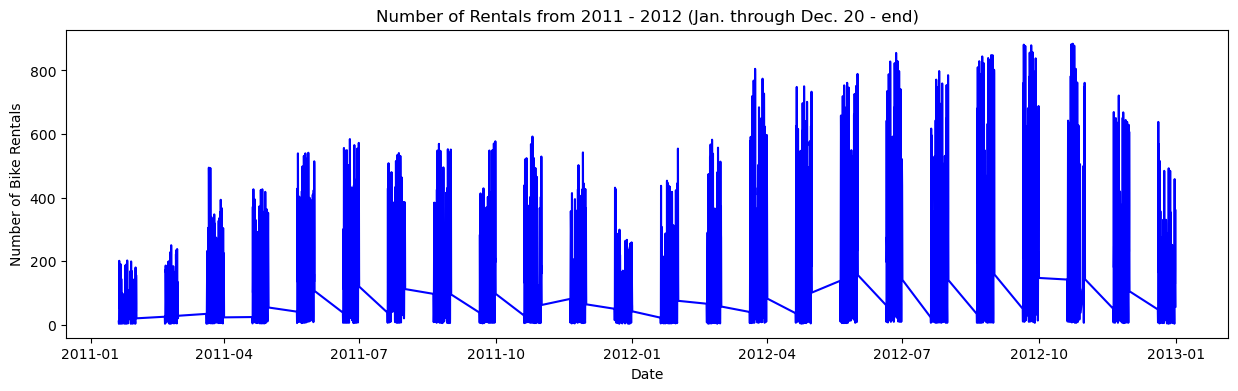

In [72]:
#Visualing predicted data: count vs datetime 
plot_df(submission, x=submission['datetime'], y=submission['count'], title='Number of Rentals from 2011 - 2012 (Jan. through Dec. 20 - end)')